In [ ]:
## Experiment performed by:
## Akshunn Garg 23/CS/042

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Loading Data and Preprocessing

In [3]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X, y = data.data, data.target

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

In [5]:
def sigmoid(Z):
    return 1/(1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

def sigmoid_derivative(A):
    return A * (1 - A) # A = sigmiod(Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def compute_bce_loss(Y, Y_hat, eps=1e-15):
    Y_hat = np.clip(Y_hat, eps, 1 - eps)
    return -np.mean(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))

def compute_mse_loss(Y, Y_hat):
    return np.mean(np.square(Y - Y_hat))

ANN Class Definition

In [6]:
class MyANNClassifier:
    def __init__(self, layer_dims, learning_rate=0.01, n_iterations=1000, loss='bce'):
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.loss = loss
        self.parameters_ = self._initialize_parameters()
        self.costs_ = []
        
    def _initialize_parameters(self):
        np.random.seed(42)
        parameters = {}
        for i in range(1, len(self.layer_dims)):
            parameters[f'W{i}'] = np.random.randn(self.layer_dims[i], self.layer_dims[i-1]) * 0.01
            parameters[f'B{i}'] = np.zeros((self.layer_dims[i], 1))

        return parameters        

    def _forward_propogation(self, X):
        self.X = X
        A = X
        cache = []
        for i in range(1, len(self.layer_dims)):
            W = self.parameters_[f'W{i}']
            b = self.parameters_[f'B{i}']
            Z = W @ A + b # (n_input, n_previous_output) * (n_previous_output, 1)

            if i == len(self.layer_dims) - 1: # Last Layer
                A = sigmoid(Z)
            else:
                A = relu(Z)

            cache.append((A, Z))

        return A, cache

    def _backward_propogation(self, Y, Y_hat, cache):
        grads = {}
        m = Y.shape[1]
        L = len(self.layer_dims) - 1

        # Output Layer
        A_L, Z_L = cache[-1]
        if self.loss == 'bce':
            dA = -np.divide(Y, Y_hat) + np.divide(1 - Y, 1 - Y_hat)
        elif self.loss == 'mse':
            dA = 2 * (Y_hat - Y)

        dZ = dA * sigmoid_derivative(A_L)
        A_prev = cache[-2][0] if len(cache) > 1 else self.X

        grads[f'dW{L}'] = (1/m) * (dZ @ A_prev.T)
        grads[f'db{L}'] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = self.parameters_[f'W{L}'].T @ dZ

        # Hidden Layers
        for i in reversed(range(1, L)):
            A, Z = cache[i-1]
            
            dZ = dA_prev * relu_derivative(Z)
            A_prev = cache[i-2][0] if i > 1 else self.X
            grads[f'dW{i}'] = (1/m) * (dZ @ A_prev.T)
            grads[f'db{i}'] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
            if i > 1:
                dA_prev = self.parameters_[f'W{i}'].T @ dZ

        return grads

    def _update_parameters(self, grads):
        L = len(self.layer_dims) - 1
        for i in range(1, L + 1):
            self.parameters_[f'W{i}'] -= self.learning_rate * grads[f'dW{i}']
            self.parameters_[f'B{i}'] -= self.learning_rate * grads[f'db{i}']

    def fit(self, X, y):
        X = X.T
        y = y.reshape(1, -1)
        
        for i in range(1, self.n_iterations+1):
            Y_hat, cache = self._forward_propogation(X)
            if self.loss == 'bce':
                loss = compute_bce_loss(y, Y_hat)
            elif self.loss == 'mse':
                loss = compute_mse_loss(y, Y_hat)

            if i % 100 == 0:
                print(f"Iteration {i}/{self.n_iterations}, Loss: {loss:.4f}")

            grads = self._backward_propogation(y, Y_hat, cache)
            self._update_parameters(grads)

            self.costs_.append(loss)
    
    def predict(self, X):
        X = X.T
        
        Y_hat, _ = self._forward_propogation(X)
        predictions = (Y_hat > 0.5).astype(int)

        return predictions.flatten()

Model 1 - BSE Loss

In [7]:
from sklearn.metrics import classification_report

layer_dims = [30, 10, 1]

model1 = MyANNClassifier(layer_dims, learning_rate=0.01, n_iterations=1000, loss='bce')
model1.fit(X_train_scaled, y_train)
y_pred = model1.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

Iteration 100/1000, Loss: 0.6802
Iteration 200/1000, Loss: 0.6706
Iteration 300/1000, Loss: 0.6578
Iteration 400/1000, Loss: 0.6224
Iteration 500/1000, Loss: 0.5232
Iteration 600/1000, Loss: 0.3796
Iteration 700/1000, Loss: 0.2726
Iteration 800/1000, Loss: 0.2098
Iteration 900/1000, Loss: 0.1729
Iteration 1000/1000, Loss: 0.1499
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        63
           1       0.98      0.98      0.98       108

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



Model 2 - MSE Loss

In [8]:
from sklearn.metrics import classification_report

layer_dims = [30, 10, 1]

model2 = MyANNClassifier(layer_dims, learning_rate=0.001, n_iterations=1000, loss='mse')
model2.fit(X_train_scaled, y_train)
y_pred = model2.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

Iteration 100/1000, Loss: 0.2496
Iteration 200/1000, Loss: 0.2492
Iteration 300/1000, Loss: 0.2488
Iteration 400/1000, Loss: 0.2485
Iteration 500/1000, Loss: 0.2481
Iteration 600/1000, Loss: 0.2477
Iteration 700/1000, Loss: 0.2474
Iteration 800/1000, Loss: 0.2471
Iteration 900/1000, Loss: 0.2467
Iteration 1000/1000, Loss: 0.2464
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.63      1.00      0.77       108

    accuracy                           0.63       171
   macro avg       0.32      0.50      0.39       171
weighted avg       0.40      0.63      0.49       171



c:\Users\Akshunn Garg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Akshunn Garg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Akshunn Garg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

Model 3 - Deeper Architecture

In [9]:
from sklearn.metrics import classification_report

layer_dims = [30, 10, 5, 1]

model3 = MyANNClassifier(layer_dims, learning_rate=0.001, n_iterations=1000, loss='bce')
model3.fit(X_train_scaled, y_train)
y_pred = model3.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

Iteration 100/1000, Loss: 0.6916
Iteration 200/1000, Loss: 0.6902
Iteration 300/1000, Loss: 0.6888
Iteration 400/1000, Loss: 0.6874
Iteration 500/1000, Loss: 0.6862
Iteration 600/1000, Loss: 0.6850
Iteration 700/1000, Loss: 0.6838
Iteration 800/1000, Loss: 0.6827
Iteration 900/1000, Loss: 0.6817
Iteration 1000/1000, Loss: 0.6807
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.63      1.00      0.77       108

    accuracy                           0.63       171
   macro avg       0.32      0.50      0.39       171
weighted avg       0.40      0.63      0.49       171



c:\Users\Akshunn Garg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Akshunn Garg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Akshunn Garg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

Scikit Learn Model

In [10]:
from sklearn.neural_network import MLPClassifier

model_sklearn = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='sgd', max_iter=1000, learning_rate='constant', learning_rate_init=0.001, batch_size=X_train_scaled.shape[0], momentum=0.0, n_iter_no_change=1001, alpha=0.0, random_state=42)

model_sklearn.fit(X_train_scaled, y_train)
y_pred = model_sklearn.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        63
           1       0.97      0.91      0.94       108

    accuracy                           0.92       171
   macro avg       0.91      0.93      0.92       171
weighted avg       0.93      0.92      0.92       171



c:\Users\Akshunn Garg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


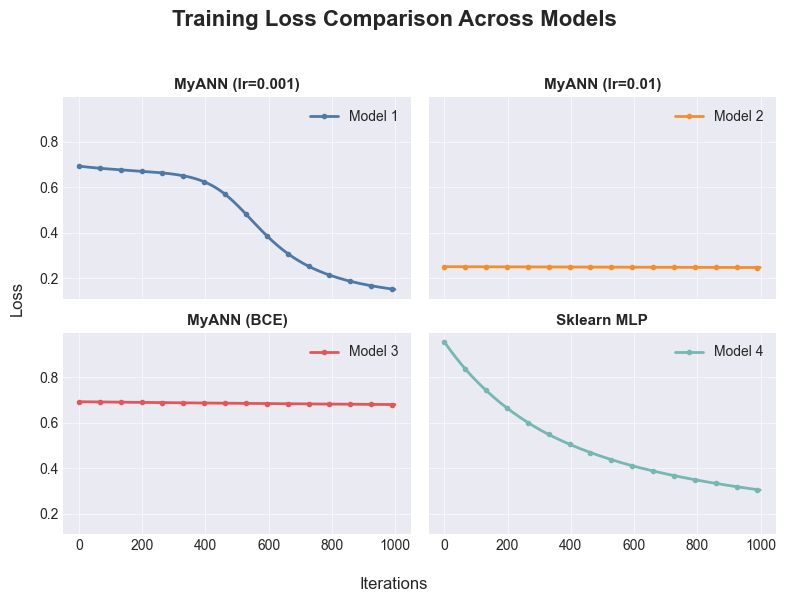

In [11]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")

rows, cols = 2, 2
fig, ax = plt.subplots(rows, cols, figsize=(8, 6), sharex=True, sharey=True)

models = [model1, model2, model3, model_sklearn]
titles = ["MyANN (lr=0.001)", "MyANN (lr=0.01)", "MyANN (BCE)", "Sklearn MLP"]
colors = ["#4E79A7", "#F28E2B", "#E15759", "#76B7B2"]

for i, model in enumerate(models):
    r, c = i // cols, i % cols
    losses = getattr(model, "costs_", None) or getattr(model, "loss_curve_", None)
    
    ax[r][c].plot(
        range(len(losses)),
        losses,
        color=colors[i],
        linewidth=2,
        marker="o",
        markersize=3,
        markevery=max(len(losses)//15, 1),
        label=f"Model {i+1}",
    )
    ax[r][c].set_title(titles[i], fontsize=11, fontweight="semibold")
    ax[r][c].grid(alpha=0.6)
    ax[r][c].legend(frameon=False, loc="best")

fig.suptitle("Training Loss Comparison Across Models", fontsize=16, fontweight="bold", y=0.98)
fig.supxlabel("Iterations", fontsize=12)
fig.supylabel("Loss", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
